In [1]:
import datajoint as dj
from ibl_pipeline import behavior, ephys
import numpy as np
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
from ibl_pipeline.plotting import plotting_utils_ephys as putils
import scipy.signal as signal

Connecting shan@datajoint.internationalbrainlab.org:3306


In [23]:
def create_psth_plot(trials, align_event, nbins, window_size, x_lim=[-1, 1], show_plot=False):
    spk_times = (trials & 'event="{}"'.format(align_event)).fetch('trial_spike_times')
    mean_counts = np.divide(
        np.histogram(np.hstack(spk_times),
                     range=x_lim,
                     bins=nbins)[0],
        len(spk_times))
    time_bins=np.linspace(x_lim[0], x_lim[1], num=nbins)
    
    # convolve with a box-car filter
    dt = np.mean(np.diff(time_bins))
    psth = np.divide(signal.convolve(mean_counts, signal.boxcar(window_size), mode='same'),
                     window_size*dt)
    fig = plt.figure(dpi=300, frameon=False, figsize=[10, 5])
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.plot(time_bins, psth, markeredgewidth=0)

    ax.set_axis_off()
    fig.add_axes(ax)

    # hide the axis
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # set the limits to be exactly what you want
    ax.set_xlim(x_lim[0], x_lim[1])
    ax.axvline(0, linewidth=2, alpha=0.5, color='k', label=align_event)
    ax.legend(loc=[0.01, 0.87], prop=dict(size=14))
    y_lim = ax.get_ylim()

    # save the figure with `pad_inches=0` to remove
    # any padding in the image
    import tempfile
    temp = tempfile.NamedTemporaryFile(suffix=".png")
    fig.savefig(temp.name, pad_inches=0)

    if not show_plot:
        plt.close(fig)

    import base64
    with open(temp.name, "rb") as image_file:
        encoded_string = base64.b64encode(image_file.read())
    temp.close()
    return encoded_string, y_lim

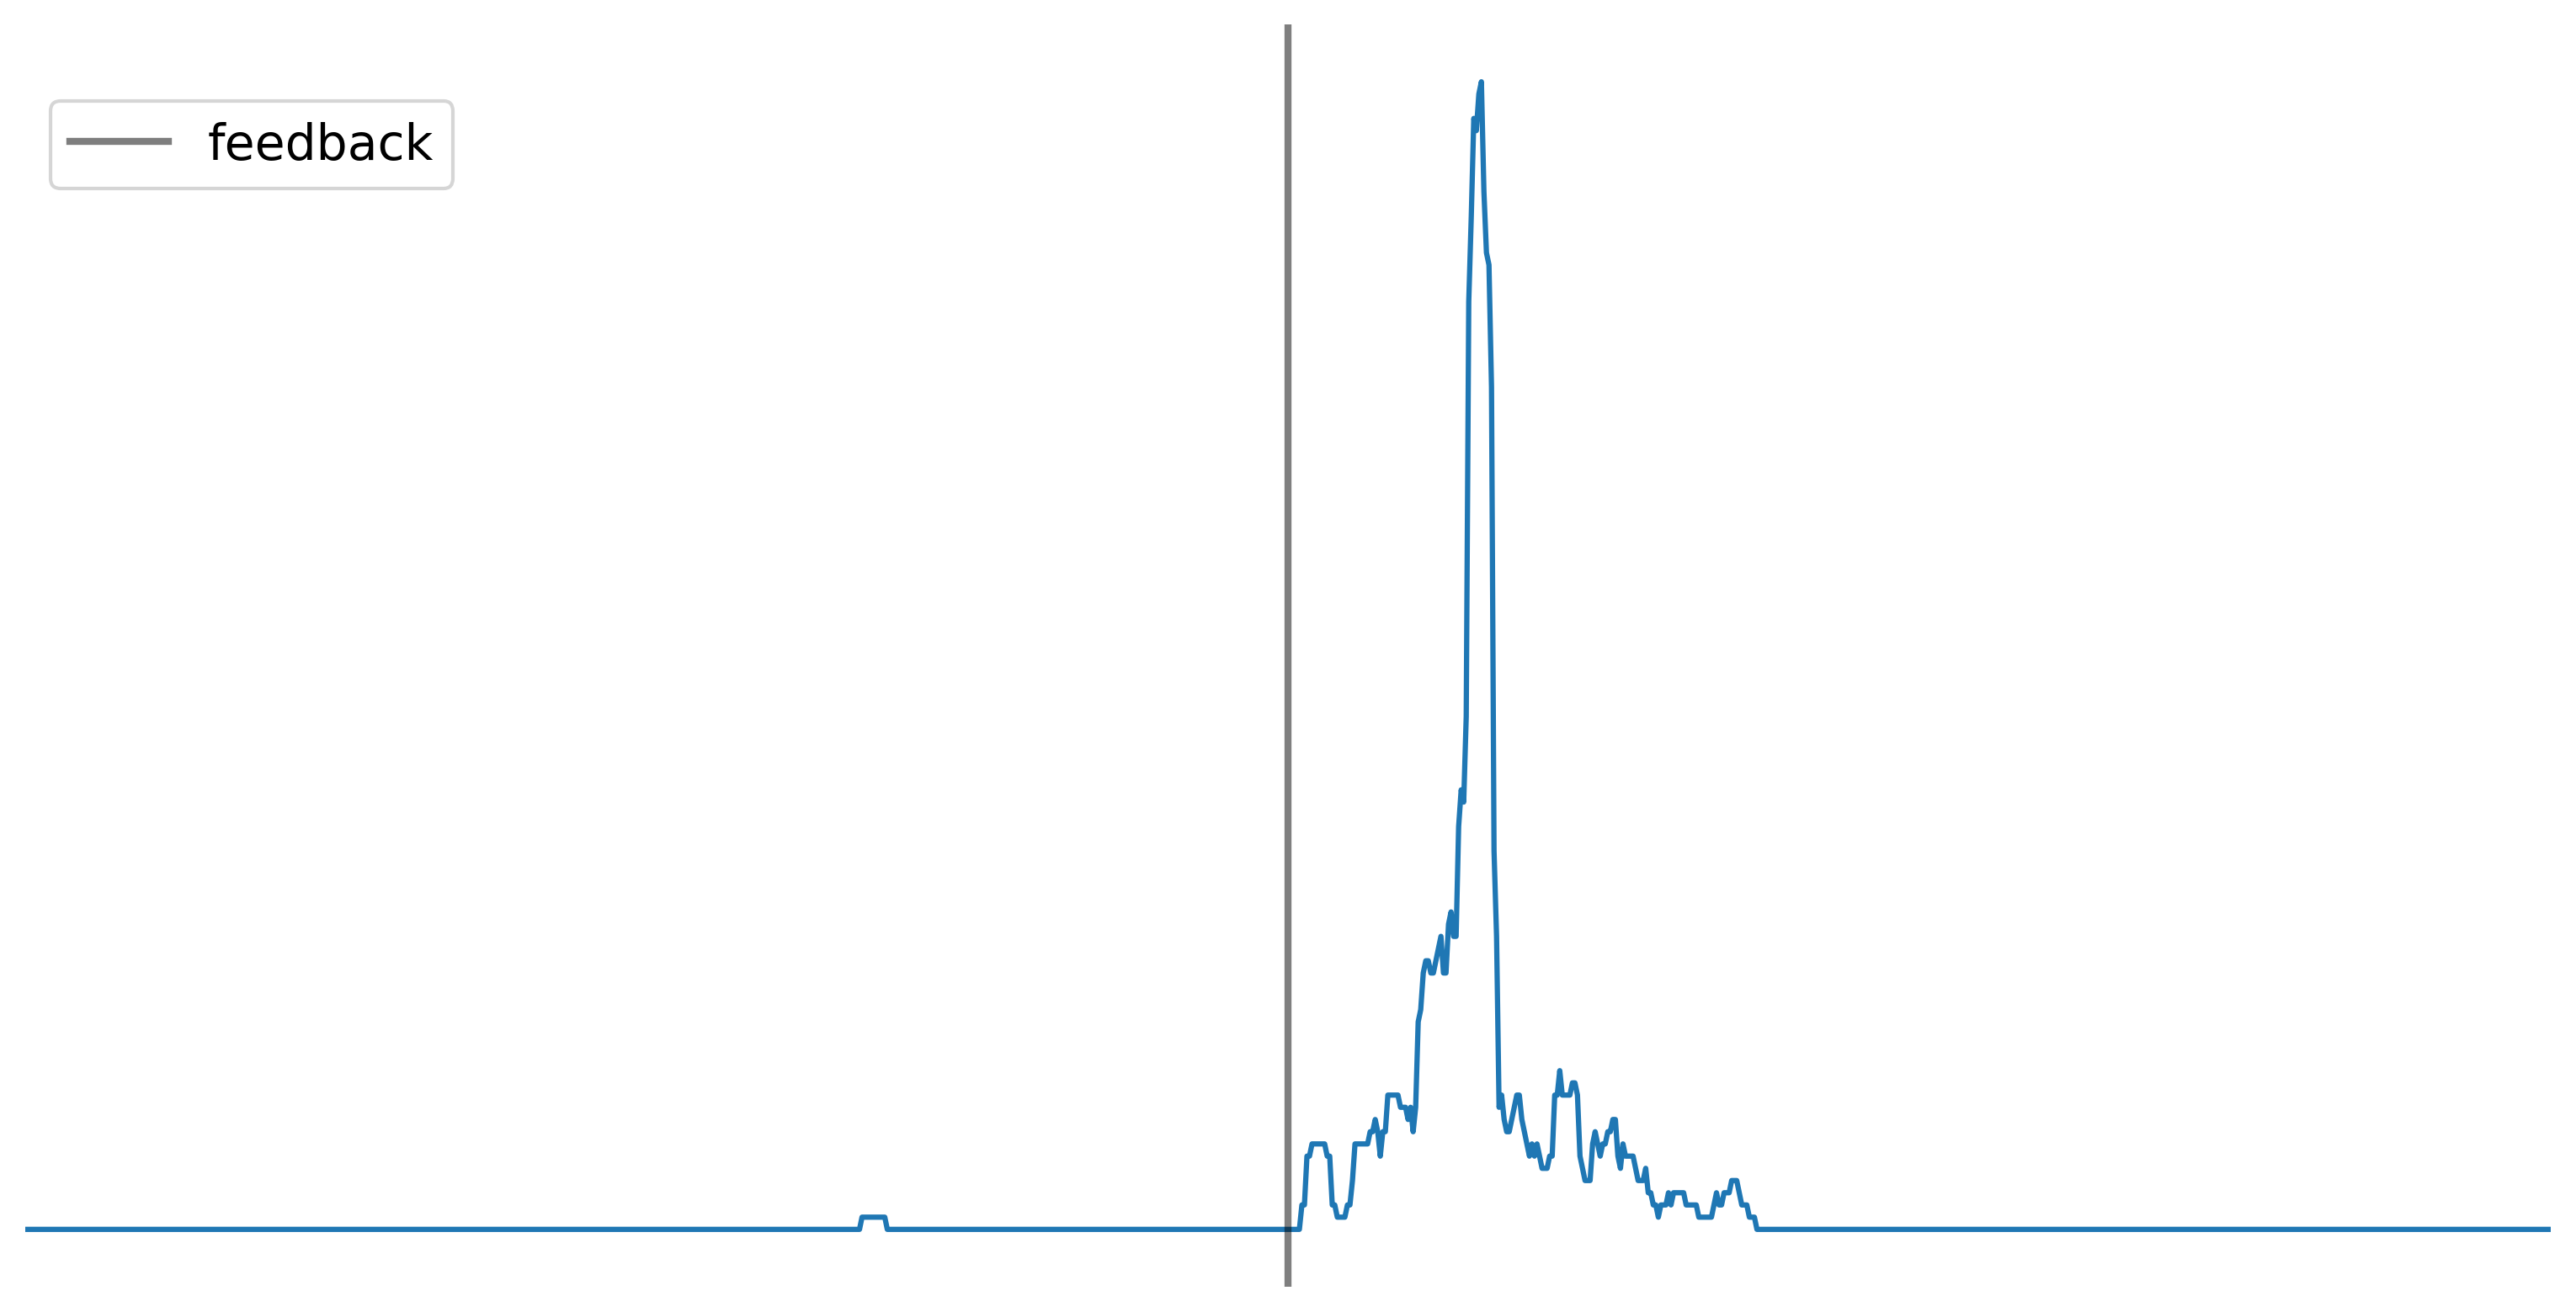

In [24]:
cluster = ephys.Cluster & 'cluster_id=14'
trials_all = (behavior.TrialSet.Trial * ephys.TrialSpikes & cluster).proj(
    'trial_start_time', 'trial_stim_on_time', 'trial_response_time', 'trial_feedback_time',
    'trial_response_choice', 'trial_spike_times',
    trial_duration='trial_end_time-trial_start_time',
    trial_signed_contrast='trial_stim_contrast_right - trial_stim_contrast_left'
) & 'trial_duration < 5' & 'trial_response_choice!="No Go"'

trials_left = trials_all & 'trial_response_choice="CW"' & 'trial_signed_contrast < 0'
trials_right = trials_all & 'trial_response_choice="CCW"' & 'trial_signed_contrast > 0'
trials = trials_all & [trials_right.proj(), trials_left.proj()]
align_event = 'feedback'
x_lim = [-1, 1]
encoded_string, y_lim = create_psth_plot(trials, align_event, 1000, 10, show_plot=True)

In [25]:
data = go.Scatter(
    x=x_lim,
    y=y_lim,
    mode='markers',
    marker=dict(opacity=0)
)

layout = go.Layout(
    images=[dict(
      source='data:image/png;base64, ' + encoded_string.decode(),
      sizex=x_lim[1] - x_lim[0],
      sizey=y_lim[1] - y_lim[0],
      x=x_lim[0],
      y=y_lim[1],
      xref='x',
      yref='y',
      sizing='stretch',
      layer='below'
    )],
    width=580,
    height=370,
    margin=go.layout.Margin(
        l=50,
        r=30,
        b=40,
        t=80,
        pad=0
    ),
    title=dict(
        text='Raster, aligned to {}'.format(align_event),
        y=0.87
    ),
    xaxis=dict(
        title='Time (sec)',
        range=x_lim,
        showgrid=False
    ), 
    yaxis=dict(
        title='Firing rate (spks/sec)',
        range=y_lim,
        showgrid=False
    ),
)

fig = go.Figure(data=[data], layout=layout)
plotly.offline.iplot(fig)

In [26]:
import json
f = open("psth.json","w")
s = json.dumps(fig.to_plotly_json())
f.write(s)
f.close()